# Sleep Stage Analysis using EEG Data

This project analyzes EEG data from 10 subjects (5 normal, 3 insomniac, 2 narcoleptic) for the purpose of visualizing and comparing sleep stage patterns. Data includes `.edf` EEG files, `.txt` annotations, and `.edf.st` annotations, all sourced from the CAP Sleep Database.

The final goal is to visualize sleep patterns across different conditions and stages i.e. Wakeful (w), s1, s2, s3, Rapid Eye Movement (REM)

# Setup and Data Loading

We mount Google Drive, install necessary libraries, and prepare to read `.edf` EEG signals, `.txt` annotations, and `.edf.st` stage info.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install necessary libraries
!pip install mne numpy scipy pandas matplotlib seaborn gdown openpyxl

In [ ]:
# Import libraries
import mne
import os
import numpy as np
import pandas as pd
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping to multiple lines
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [ ]:
data_dir = "/content/drive/MyDrive/CAP_Sleep_Data/"

# Preprocessing Required
The `.txt` files have header lines that jave to be parsed out and annotations for sleep stages are to be extracted.

Extracting the annotations from `.txt` files and converting them into a dataframe.

In [ ]:
def convert_sleep_data_to_df(file_content):
    lines = file_content.strip().split('\n')
    # Find true header line dynamically
    header_index = None
    for i, line in enumerate(lines):
        if 'Sleep Stage' in line and 'Time' in line:
            header_index = i
            break
    if header_index is None:
        print("❌ Could not find valid header line. Aborting!")
        return pd.DataFrame()
    # Extract headers
    columns = [col.strip().replace('\u200b', '') for col in lines[header_index].split('\t')]
    # Extract data rows only after header
    data_rows = []
    for line in lines[header_index + 1:]:
        if line.strip():
            data_rows.append([val.strip().replace('\u200b', '') for val in line.split('\t')])
    df = pd.DataFrame(data_rows, columns=columns)
    df.columns = df.columns.str.strip().str.replace('\u200b', '')
    # Debug column names
    print("Cleaned columns:", df.columns.tolist())
    # Convert time
    if 'Time [hh:mm:ss]' in df.columns:
        df['Time [hh:mm:ss]'] = pd.to_datetime(df['Time [hh:mm:ss]'], format='%H:%M:%S', errors='coerce').dt.time
    else:
        print("Column 'Time [hh:mm:ss]' not found!")
    # Convert duration
    if 'Duration[s]' in df.columns:
        df['Duration[s]'] = pd.to_numeric(df['Duration[s]'], errors='coerce')
    else:
        print("Column 'Duration[s]' not found!")
    return df

In [ ]:
# Load data for each subject
subjects = ['n1','n2','n3','n4','n5','ins1','ins2','ins3','narco1','narco2']
for subject in subjects:
    filepath = f'{data_dir}/{subject}.txt'
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            content = file.read()
        print(f'PROCESSING ANNOTATIONS FROM {subject}.txt')
        df = convert_sleep_data_to_df(content)
        globals()[f'df_{subject}'] = df
        print(df.head())
        print(f"Total rows: {len(df)}")
        print(df.info())
    except FileNotFoundError:
        print(f"File not found: {filepath}")
    except Exception as e:
        print(f"Error processing {subject}: {e}")

PROCESSING ANNOTATIONS FROM n1.txt
Cleaned columns: ['Sleep Stage', 'Position', 'Time [hh:mm:ss]', 'Event', 'Duration[s]', 'Location']
  Sleep Stage          Position Time [hh:mm:ss]     Event  Duration[s] Location
0           W  Unknown Position        22:09:33  SLEEP-S0           30  ROC-LOC
1           W  Unknown Position        22:10:03  SLEEP-S0           30  ROC-LOC
2           W  Unknown Position        22:10:33  SLEEP-S0           30  ROC-LOC
3           W  Unknown Position        22:11:03  SLEEP-S0           30  ROC-LOC
4           W  Unknown Position        22:11:33  SLEEP-S0           30  ROC-LOC
Total rows: 1677
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sleep Stage      1677 non-null   object
 1   Position         1677 non-null   object
 2   Time [hh:mm:ss]  1677 non-null   object
 3   Event            1677 non-null  

# Hypnograms
A hypnogram is a timeline of sleep stages across the night, showing transitions between Wake, N1, N2, N3, and REM. It helps visualize sleep quality, stage duration, and disruptions in an easy-to-read format.
Deeper stages of sleep are shown deeper on the y-axis.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
# Sleep stage Y-axis mapping (lower is deeper)
# Sleep stage Y-axis mapping (higher is lighter sleep)
stage_order = {'W': 4, 'REM': 3, 'S1': 2, 'S2': 1, 'S3': 0}
stage_labels = {v: k for k, v in stage_order.items()}
def plot_clean_hypnogram(df, person_label):
    df = df.copy()
    df['Parsed Time'] = pd.to_datetime(df['Time [hh:mm:ss]'], format='%H:%M:%S', errors='coerce')
    df = df.dropna(subset=['Parsed Time'])
    #valid sleep stages
    df = df[df['Sleep Stage'].isin(stage_order.keys())]
    df['StageCode'] = df['Sleep Stage'].map(stage_order)
    # Align time to a common 10 PM start
    ref_date = df['Parsed Time'].dt.date.dropna().min()
    night_start = datetime.combine(ref_date, datetime.strptime("22:00:00", "%H:%M:%S").time())
    if df['Parsed Time'].min().time() < datetime.strptime("22:00:00", "%H:%M:%S").time():
        night_start -= timedelta(days=1)
    df['PlotTime'] = df['Parsed Time'].apply(lambda t: night_start + ((t - night_start) % timedelta(days=1)))
    # MCAP event times
    mcap_times = df[df['Event'].str.startswith('MCAP', na=False)]['Parsed Time']
    mcap_plot_times = [night_start + ((t - night_start) % timedelta(days=1)) for t in mcap_times]
    # Plot it
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df['PlotTime'], df['StageCode'], drawstyle='steps-post', linewidth=2, label='Sleep Stage')
    # Overlay MCAP events
    for t in mcap_plot_times:
        ax.plot(t, -0.5, 'ro', markersize=1)
    ax.set_yticks(list(stage_labels.keys()))
    ax.set_yticklabels([stage_labels[k] for k in stage_labels])
    # ax.invert_yaxis()
    # Set timeline from 10 PM to 8 AM
    start_time = night_start
    end_time = night_start + timedelta(hours=10)
    ax.set_xlim([start_time, end_time])
    ax.set_xticks([start_time + timedelta(hours=h) for h in range(11)])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_title(f'Hypnogram - {person_label}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Sleep Stage')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

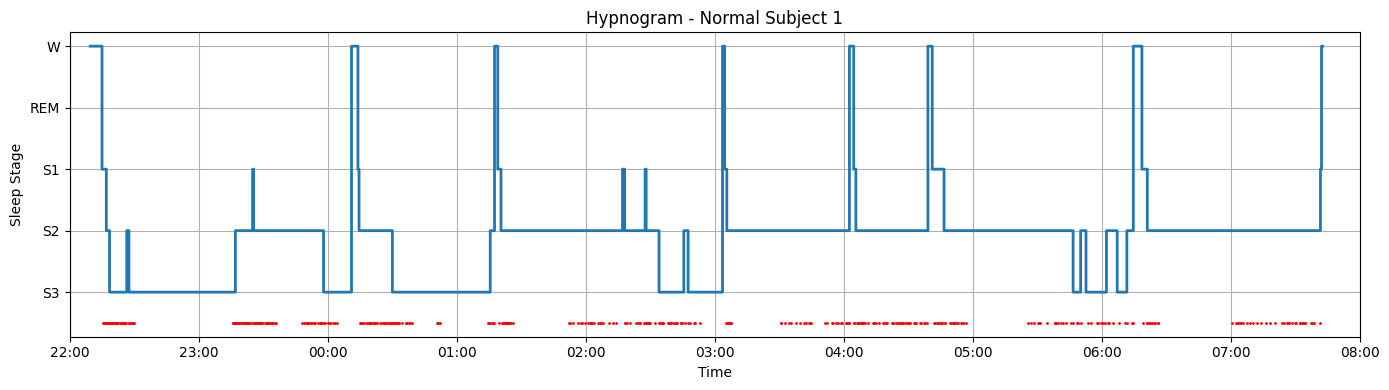

In [ ]:
plot_clean_hypnogram(df_n1, "Normal Subject 1")

This hypnogram displays a typical, healthy sleep cycle. The subject progresses through sleep stages in regular cycles, with deep sleep (S3) appearing prominently in the early part of the night and REM sleep becoming more frequent in the later hours. Brief awakenings are normal and limited. MCAP events (in red) are evenly distributed and sparse, suggesting stable and undisturbed sleep architecture.

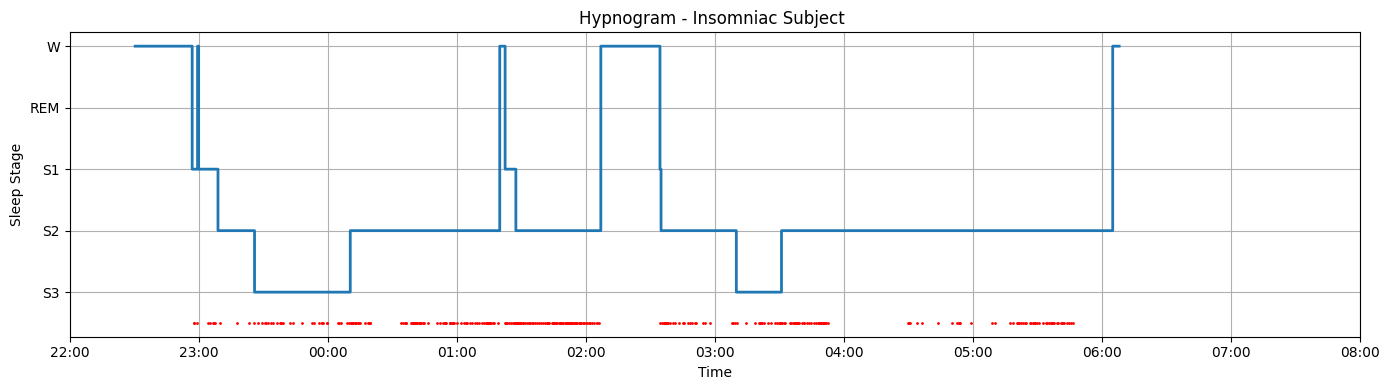

In [ ]:
plot_clean_hypnogram(df_ins1, "Insomniac Subject ")

This subject shows clear signs of disrupted sleep. Long periods of wakefulness are seen, especially at the beginning and middle of the night. Transitions between stages are less frequent, and REM sleep is notably absent or very limited. MCAP events are more clustered, hinting at micro-arousals or instability in sleep continuity—hallmarks of insomnia.

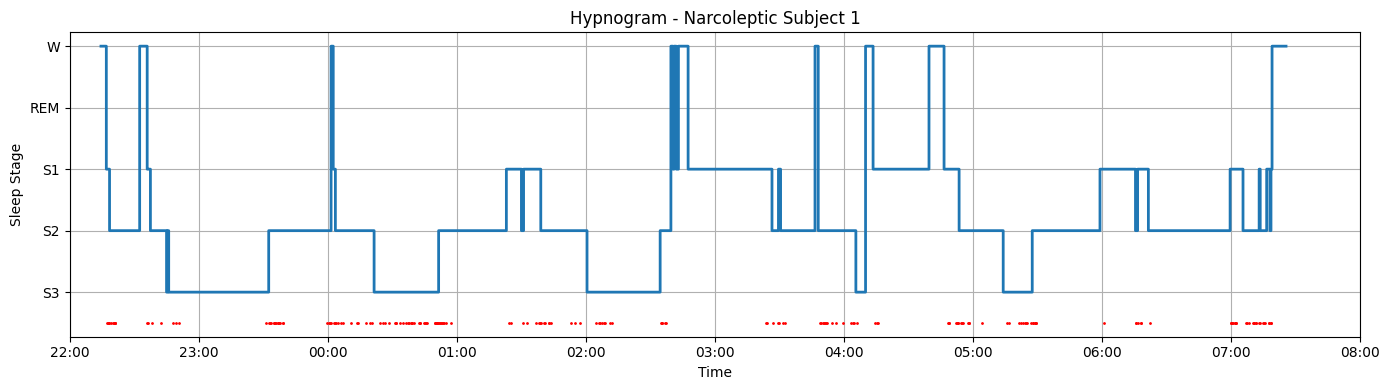

In [ ]:
plot_clean_hypnogram(df_narco1, "Narcoleptic Subject 1")

The hypnogram indicates frequent and abrupt transitions between wake, REM, and light sleep stages. REM sleep appears unusually early and recurs throughout the night, which is a classic marker of narcolepsy. Sleep cycles are fragmented, with reduced time spent in deep sleep (S3). High MCAP density aligns with disturbed and unstable sleep.

# Power analysis

Band power analysis measures the strength of brainwave activity in specific frequency ranges Delta (0.5–4 Hz) for deep sleep, Theta (4–8 Hz) for light sleep, Alpha (8–13 Hz) for relaxed wakefulness, and Beta (13–30 Hz) for alertness. It reveals how brain activity varies across sleep stages.

In [ ]:
from scipy.signal import welch
# EDF + Annotation Loader Using External DataFrame
def load_edf_with_df_annotations(edf_file, ann_df):
    print(f"📥 Loading EDF: {edf_file}")
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    raw.set_eeg_reference('average', projection=True)
    if ann_df is not None and not ann_df.empty:
        onsets = []
        durations = []
        descriptions = []
        base_time = ann_df['Time [hh:mm:ss]'].iloc[0]
        if isinstance(base_time, str):
            base_time = datetime.strptime(base_time, "%H:%M:%S").time()
        base_sec = base_time.hour * 3600 + base_time.minute * 60 + base_time.second
        for _, row in ann_df.iterrows():
            t = row['Time [hh:mm:ss]']
            if isinstance(t, str):
                t = datetime.strptime(t, "%H:%M:%S").time()
            onset_sec = (t.hour * 3600 + t.minute * 60 + t.second) - base_sec
            onsets.append(onset_sec)
            durations.append(row['Duration[s]'])
            descriptions.append(row['Sleep Stage'])
        annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)
        raw.set_annotations(annotations)
        print(f"{len(annotations)} annotations from DataFrame set.")
    else:
        print("No valid annotation DataFrame provided.")
    return raw, None

# Band Power Computation Function
def compute_band_power_df(raw, annotations, bands=None):
    if bands is None:
        bands = {
            'Delta': (0.5, 4),
            'Theta': (4, 8),
            'Alpha': (8, 12),
            'Beta': (12, 30)
        }
    picks = mne.pick_types(raw.info, eeg=True, exclude='bads')
    band_power_records = []
    if annotations is None:
        print("No annotations found. Skipping band power computation.")
        return pd.DataFrame()
    for onset, duration, stage in zip(annotations.onset, annotations.duration, annotations.description):
        start = int(onset * raw.info['sfreq'])
        stop = int((onset + duration) * raw.info['sfreq'])
        if stop > len(raw.times):
            continue
        data, _ = raw[picks, start:stop]
        data = np.mean(data, axis=0)
        if len(data) < raw.info['sfreq'] * 2:
            continue
        freqs, psd = welch(data, fs=raw.info['sfreq'], nperseg=4 * int(raw.info['sfreq']))
        total_power = np.sum(psd)
        if total_power == 0:
            continue
        for band_name, (low, high) in bands.items():
            idx_band = np.logical_and(freqs >= low, freqs <= high)
            band_power = np.mean(psd[idx_band])
            band_power_records.append({
                'Stage': stage,
                'Band': band_name,
                'Power': band_power
            })
    df = pd.DataFrame(band_power_records)
    # Normalization
    if not df.empty:
        df['Power'] = df.groupby('Band')['Power'].transform(lambda x: (x - x.mean()) / (x.std() + 1e-8))
    return df

# Plotting Function
def plot_band_power_comparison(df, subject_id="Unknown"):
    if df.empty:
        print("Empty DataFrame received for plotting.")
        return
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Band', y='Power', hue='Stage', data=df, palette='Set2')
    plt.title(f'EEG Band Power Across Sleep Stages - {subject_id}')
    plt.xlabel('Frequency Band')
    plt.ylabel('Normalized Power (unitless)')
    plt.legend(title='Sleep Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

**Band power for normal subject**

Normal Individual: Expect higher Delta and Theta power during wakefulness and deep sleep (S3, S4), with minimal Alpha and Beta activity, reflecting typical brain activity patterns consistent with healthy sleep cycles.

📥 Loading EDF: /content/drive/MyDrive/CAP_Sleep_Data//n1.edf


<ipython-input-44-16f5e6709f64>:5: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
<ipython-input-44-16f5e6709f64>:5: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
<ipython-input-44-16f5e6709f64>:5: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<ipython-input-44-16f5e6709f64>:24: RuntimeWarning: Omitted 1300 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


1677 annotations from DataFrame set.


/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 2048 is greater than input length  = 1536, using nperseg = 1536
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


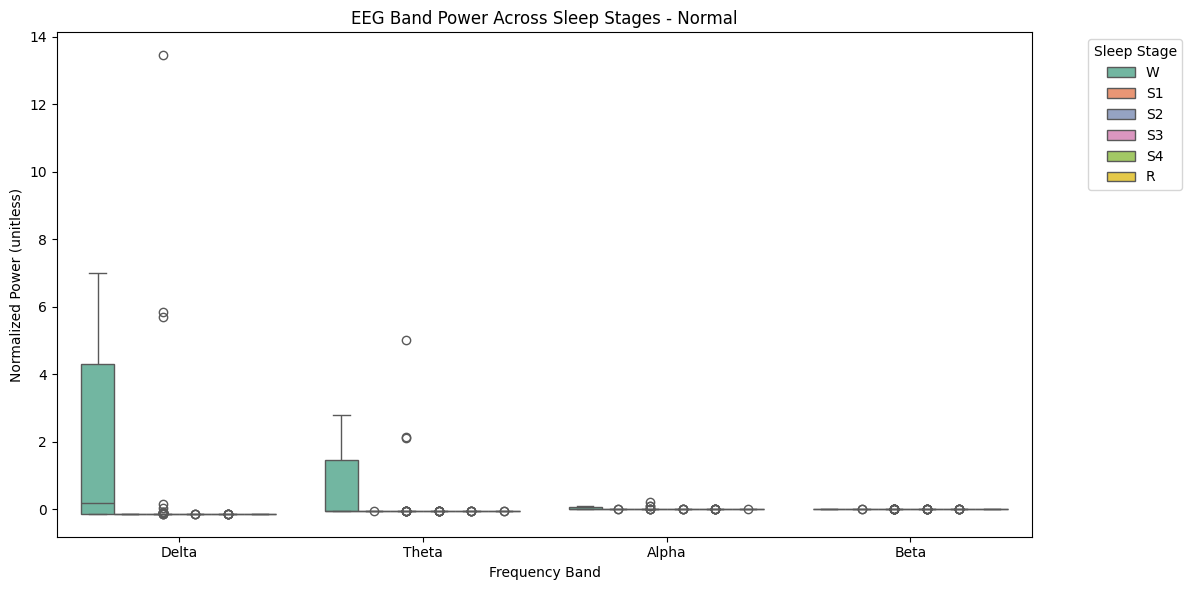

In [ ]:
edf_file = f"{data_dir}/n1.edf"
annotations_df = df_n1
raw, _ = load_edf_with_df_annotations(edf_file, annotations_df)
df_band_power = compute_band_power_df(raw, raw.annotations)
plot_band_power_comparison(df_band_power, subject_id="Normal")

This shows that a normal individual exhibits the highest normalized Delta power (around 4-5 units) during wakefulness (W), with moderate Theta power (around 2 units) across various stages, and negligible Alpha and Beta activity. This pattern reflects typical brain activity, with dominant Delta waves during wakefulness and a smooth transition to lighter sleep stages, consistent with healthy sleep architecture.

**Band power for insomniac subject**

Insomnia: Anticipate reduced Delta power and increased Alpha or Beta activity during intended sleep stages, indicating difficulty transitioning to and maintaining deep sleep, a common feature of insomnia.

📥 Loading EDF: /content/drive/MyDrive/CAP_Sleep_Data//ins1.edf


<ipython-input-44-16f5e6709f64>:5: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
<ipython-input-44-16f5e6709f64>:5: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
1225 annotations from DataFrame set.


<ipython-input-44-16f5e6709f64>:24: RuntimeWarning: Omitted 1011 annotation(s) that were outside data range.
  raw.set_annotations(annotations)
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 768, using nperseg = 768
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


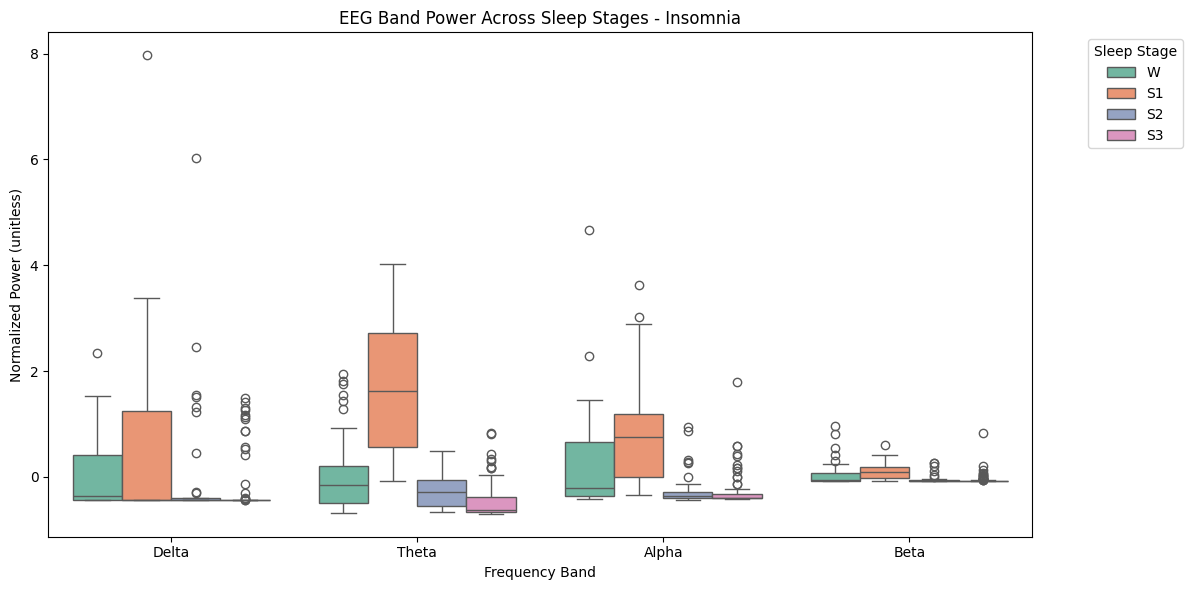

In [ ]:
edf_file = f"{data_dir}/ins1.edf"
annotations_df = df_ins1
raw, _ = load_edf_with_df_annotations(edf_file, annotations_df)
df_band_power = compute_band_power_df(raw, raw.annotations)
plot_band_power_comparison(df_band_power, subject_id="Insomnia")

This shows that individuals with insomnia exhibit elevated Theta power during the S1 sleep stage (around 3-4 units), with noticeable Delta and Alpha activity during wakefulness (W) and lighter sleep stages (S2, S3). Beta power remains low across all stages. This suggests difficulty transitioning to deeper sleep, with persistent wake-like brain activity (higher Alpha and Theta) during intended sleep periods, consistent with insomnia patterns where deep sleep (Delta dominance) is reduced.

**Band power for narcoleptic subject**

Narcolepsy: Look for irregular transitions with elevated Delta and Theta power during wakefulness or rapid eye movement (R) intrusions, reflecting disrupted sleep-wake cycles characteristic of narcolepsy.

📥 Loading EDF: /content/drive/MyDrive/CAP_Sleep_Data//narco1.edf


<ipython-input-44-16f5e6709f64>:5: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
<ipython-input-44-16f5e6709f64>:5: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
<ipython-input-44-16f5e6709f64>:5: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<ipython-input-44-16f5e6709f64>:24: RuntimeWarning: Omitted 1068 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


1320 annotations from DataFrame set.


/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 2048 is greater than input length  = 1536, using nperseg = 1536
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


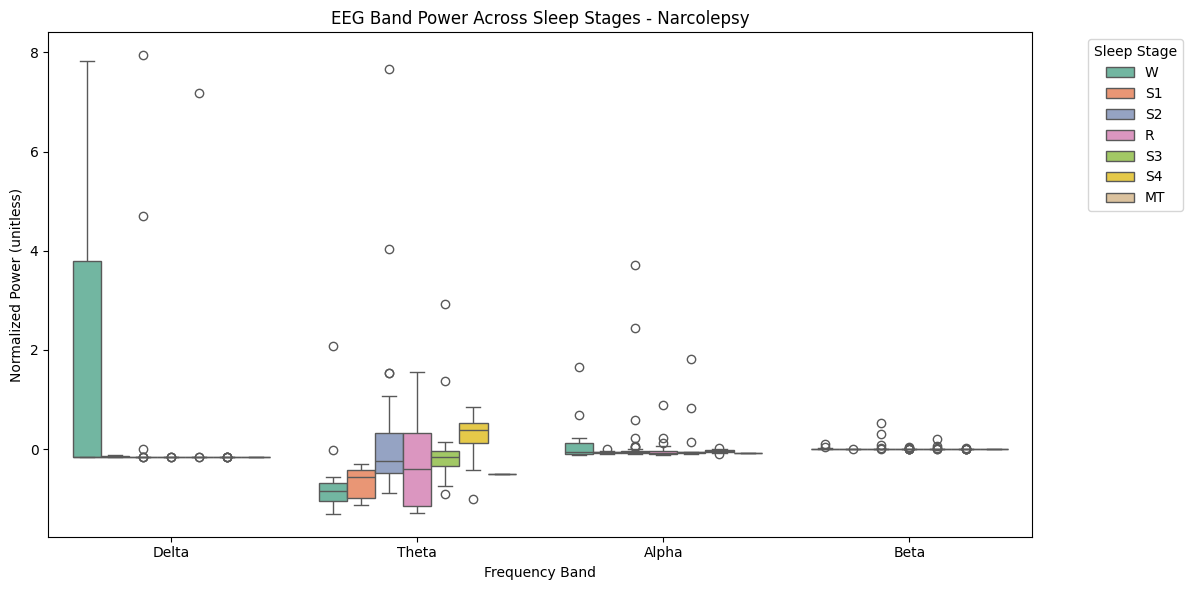

In [ ]:
edf_file = f"{data_dir}/narco1.edf"
annotations_df = df_narco1
raw, _ = load_edf_with_df_annotations(edf_file, annotations_df)
df_band_power = compute_band_power_df(raw, raw.annotations)
plot_band_power_comparison(df_band_power, subject_id="Narcolepsy")

This shows that individuals with narcolepsy exhibit a notable Delta power peak (around 4 units) during wakefulness (W), with minimal activity in other bands. Theta and Alpha bands show moderate power during S2 and R stages, while Beta power remains negligible across all stages. This pattern suggests abnormal Delta wave presence during wakefulness, a hallmark of narcolepsy, reflecting disrupted sleep-wake transitions and potential rapid entry into sleep or REM-like states.

# Sleep Stage Distribution

Normal Subject: The pie chart for a normal subject typically shows a balanced sleep structure. The majority of sleep is spent in Stage 2 and REM, with a healthy amount of deep sleep (S3) and a smaller portion in light sleep (S1) and Wake (W). This reflects stable and restorative sleep architecture.

Insomniac Subject: In insomniac subjects, the chart reveals a disproportionate amount of time in the Wake stage. Deep sleep (S3) and REM are often significantly reduced, while light stages like S1 may be scattered. This suggests fragmented, poor-quality sleep with difficulty maintaining deeper stages.

Narcoleptic Subject: Narcoleptic sleep patterns are marked by abnormal REM distribution, often with REM taking up a larger-than-usual portion. Deep sleep (S3) might be limited, and stage transitions are irregular. The chart may reflect direct transitions from Wake to REM or inconsistent cycling.

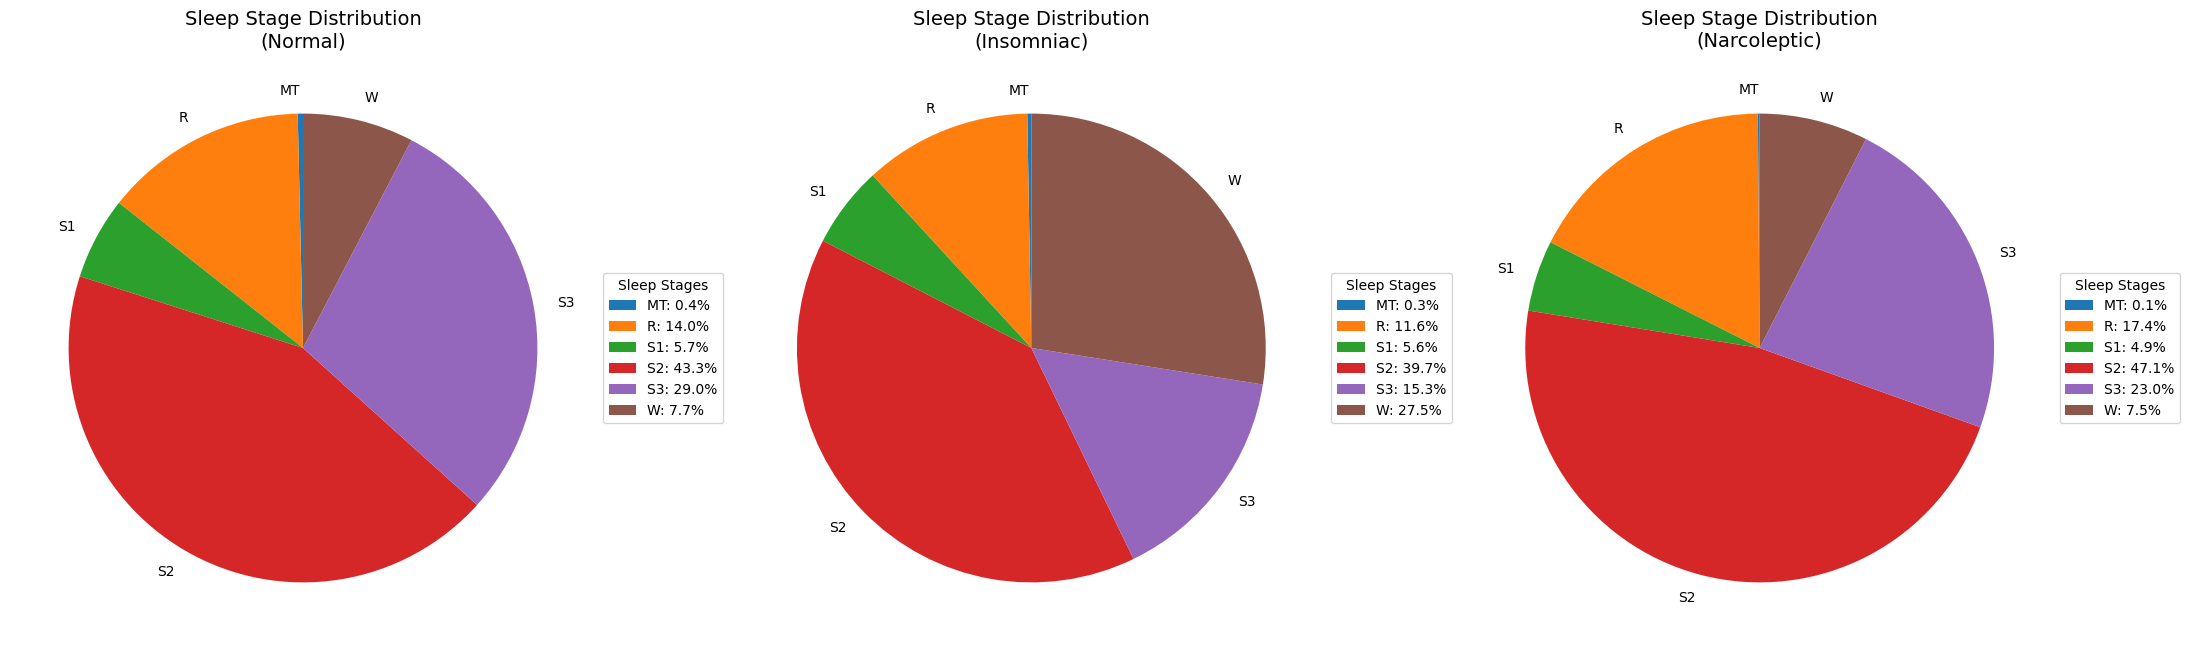

In [ ]:
import matplotlib.pyplot as plt
normal_dfs = [df_n1, df_n2, df_n3, df_n4, df_n5]
insomniac_dfs = [df_ins1, df_ins2, df_ins3]
narco_dfs = [df_narco1, df_narco2]
def combine_stage_counts(df_list):
    combined = pd.concat(df_list, ignore_index=True)
    combined['Sleep Stage'] = combined['Sleep Stage'].replace('S4', 'S3')  # Treat S4 as S3
    return combined['Sleep Stage'].value_counts().sort_index()
normal_counts = combine_stage_counts(normal_dfs)
insomniac_counts = combine_stage_counts(insomniac_dfs)
narco_counts = combine_stage_counts(narco_dfs)
# Pie Chart
def plot_pie_chart(counts_list, labels):
    fig, axs = plt.subplots(1, 3, figsize=(22, 7))
    for i, counts in enumerate(counts_list):
        wedges, texts = axs[i].pie(
            counts,
            labels=counts.index,  # Show stage labels only
            startangle=90
        )
        axs[i].set_title(f'Sleep Stage Distribution\n({labels[i]})', fontsize=14)
        # Add percentage info to legend
        percentages = counts / counts.sum() * 100
        legend_labels = [f"{stage}: {pct:.1f}%" for stage, pct in zip(counts.index, percentages)]
        axs[i].legend(
            wedges, legend_labels,
            title="Sleep Stages",
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            fontsize=10
        )
    plt.tight_layout()
    plt.show()
plot_pie_chart([normal_counts, insomniac_counts, narco_counts], ['Normal', 'Insomniac', 'Narcoleptic'])

**Normal** sleepers show a well-balanced distribution across all stages. The majority of their sleep is spent in Stage 2 (S2) at ~43%, which is typical. Deep sleep (S3) is also well-represented at ~29%, indicating healthy restorative sleep. REM accounts for ~14%, supporting cognitive processing and dreaming, while wakefulness (W) is minimal at ~7.7%, reflecting efficient sleep cycles.





**Insomniacs** exhibit disrupted sleep patterns with a 27.5% spent awake (W), nearly four times higher than normals. Deep sleep (S3) is severely reduced to 15.3%, and REM also drops to 11.6%, both signs of poor sleep quality. Although S2 still dominates (~39.7%), the loss in restorative and REM stages highlights the impact of insomnia on sleep architecture.


**Narcoleptic** subjects spend a significant amount of time in REM sleep (17.4%), higher than both normals and insomniacs, consistent with rapid REM onset often seen in narcolepsy. They maintain decent S3 (23%) and high S2 (47%) proportions, suggesting relatively preserved non-REM structure. Wake time is low (~7.5%), but the altered REM balance points to their unique sleep profile.

# Power spectral densities

Power spectral density (PSD) is a measure used to analyze the strength of various frequency components in a signal, such as brain waves in an EEG. It shows how the power (or energy) of the signal is distributed across different frequencies,in units like dB/µV²/Hz. In EEG, PSD helps identify dominant brain wave patterns (e.g., Delta, Theta, Alpha, Beta) and their intensity, providing insights into sleep stages, neurological conditions, or brain activity states.

In [ ]:
def load_edf_data(edf_file, annotation_file):
    """Loads EDF data and annotations.

    Args:
        edf_file (str): Path to the EDF file.
        annotation_file (str): Path to the annotation file.

    Returns:
        tuple: A tuple containing the raw EEG data (mne.io.Raw),
               annotations (mne.Annotations), and events (None in this case).
    """
    try:
        # Load the EDF file using MNE
        raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
        raw.set_eeg_reference('average', projection=True)

        # Load the annotations from the text file using a previously defined function
        # 'convert_sleep_data_to_df' converts annotation file content into a DataFrame
        with open(annotation_file, 'r', encoding='utf-8') as file:
            content = file.read()
        annotations_df = convert_sleep_data_to_df(content)

        # Convert annotations DataFrame into MNE Annotations object
        onsets = []
        durations = []
        descriptions = []
        base_time = annotations_df['Time [hh:mm:ss]'].iloc[0]
        if isinstance(base_time, str):
            base_time = pd.to_datetime(base_time, format="%H:%M:%S").time()
        base_sec = base_time.hour * 3600 + base_time.minute * 60 + base_time.second

        for _, row in annotations_df.iterrows():
            t = row['Time [hh:mm:ss]']
            if isinstance(t, str):
                t = pd.to_datetime(t, format="%H:%M:%S").time()
            onset_sec = (t.hour * 3600 + t.minute * 60 + t.second) - base_sec
            onsets.append(onset_sec)
            durations.append(row['Duration[s]'])
            descriptions.append(row['Sleep Stage'])

        annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)
        raw.set_annotations(annotations)  # Add annotations to the raw EEG data

        return raw, annotations, None  # Events are None in this case

    except FileNotFoundError:
        print(f"File not found: {edf_file} or {annotation_file}")
        return None, None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

In [ ]:
import matplotlib.pyplot as plt
def plot_psd_for_subject(raw, subject_id, channel='F4-C4'):
    """
    Plots and saves Power Spectral Density (PSD) for a given subject's raw EEG.

    Parameters:
    - raw: MNE Raw object
    - subject_id: string, subject label like 'n1', 'ins2'
    - channel: EEG channel to plot
    - plot_dir: directory to save the figure
    """
    try:
        if channel not in raw.ch_names:
            channel = raw.ch_names[0]

        psd = raw.compute_psd(fmax=50)

        plt.figure()
        psd.plot(picks=[channel], show=False)
        plt.title(f'Power Spectral Density ({channel}) for Subject {subject_id}')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f" Error plotting PSD for {subject_id}: {e}")

<ipython-input-6-40ea42ce2a0a>:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
<ipython-input-6-40ea42ce2a0a>:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
<ipython-input-6-40ea42ce2a0a>:14: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Cleaned columns: ['Sleep Stage', 'Position', 'Time [hh:mm:ss]', 'Event', 'Duration[s]', 'Location']


<ipython-input-6-40ea42ce2a0a>:43: RuntimeWarning: Omitted 1300 annotation(s) that were outside data range.
  raw.set_annotations(annotations)  # Add annotations to the raw EEG data


Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-7-d520fd5aaa1c>:19: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot(picks=[channel], show=False)
<ipython-input-7-d520fd5aaa1c>:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

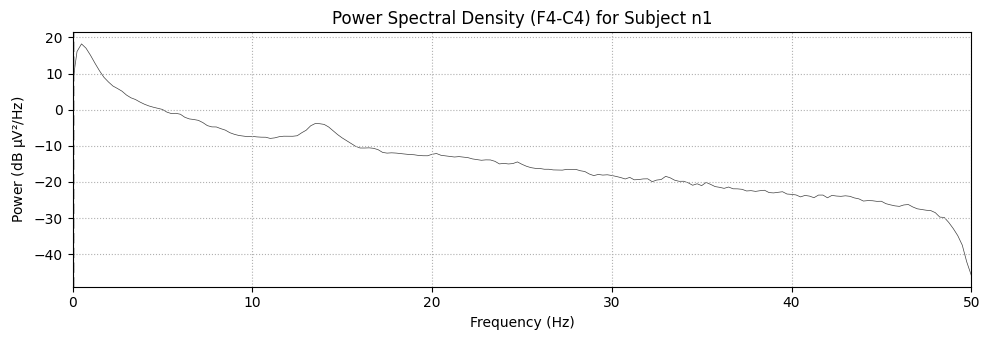

In [ ]:
edf_file = f"{data_dir}/n1.edf"
txt_file = f"{data_dir}/n1.txt"
raw, _, _ = load_edf_data(edf_file, txt_file)
plot_psd_for_subject(raw, subject_id='n1')

The power spectral density (F4-C4) plot for Subject n1, a **normal person**, shows the strongest brain activity (around 0 dB/µV²/Hz) at low frequencies below 5 Hz, which is the Delta range. This gradually drops to about -30 dB/µV²/Hz by 50 Hz as it moves through Theta, Alpha, and Beta bands. This pattern reflects typical brain waves, with the most activity at lower frequencies during a restful state, matching a healthy EEG.

<ipython-input-6-40ea42ce2a0a>:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
<ipython-input-6-40ea42ce2a0a>:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Cleaned columns: ['Sleep Stage', 'Time [hh:mm:ss]', 'Event', 'Duration[s]', 'Location']


<ipython-input-6-40ea42ce2a0a>:43: RuntimeWarning: Omitted 1226 annotation(s) that were outside data range.
  raw.set_annotations(annotations)  # Add annotations to the raw EEG data


Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-7-d520fd5aaa1c>:19: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot(picks=[channel], show=False)
<ipython-input-7-d520fd5aaa1c>:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

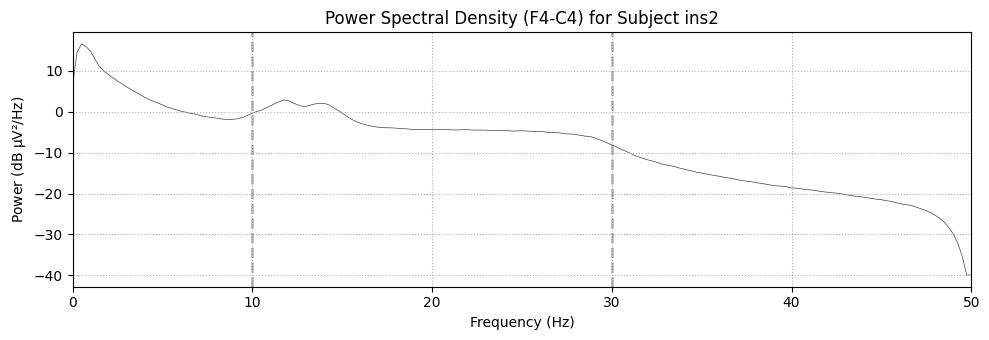

In [ ]:
edf_file = f"{data_dir}/ins2.edf"
txt_file = f"{data_dir}/ins2.txt"
raw, _, _ = load_edf_data(edf_file, txt_file)
plot_psd_for_subject(raw, subject_id='ins2')

The power spectral density (F4-C4) plot for Subject ins2, **an insomniac** shows a peak power around 0 dB/µV²/Hz at low frequencies below 5 Hz, likely in the Delta range, followed by a decline to about -30 dB/µV²/Hz by 50 Hz. A noticeable rise in power around 10-15 Hz (Alpha range) suggests increased activity, which, combined with the "ins2" label, may indicate insomnia-like patterns where wakeful brain activity persists.

<ipython-input-22-40ea42ce2a0a>:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
<ipython-input-22-40ea42ce2a0a>:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
<ipython-input-22-40ea42ce2a0a>:14: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Cleaned columns: ['Sleep Stage', 'Time [hh:mm:ss]', 'Event', 'Duration[s]', 'Location']


<ipython-input-22-40ea42ce2a0a>:43: RuntimeWarning: Omitted 1068 annotation(s) that were outside data range.
  raw.set_annotations(annotations)  # Add annotations to the raw EEG data


Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-23-d520fd5aaa1c>:19: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot(picks=[channel], show=False)
<ipython-input-23-d520fd5aaa1c>:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

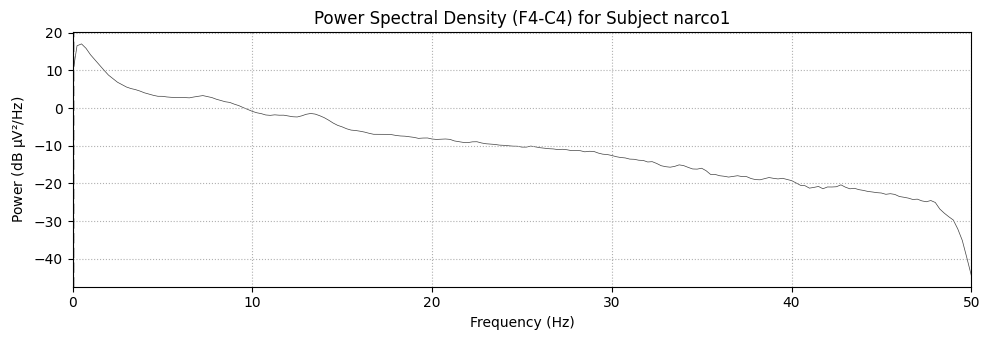

In [ ]:
edf_file = f"{data_dir}/narco1.edf"
txt_file = f"{data_dir}/narco1.txt"
raw, _, _ = load_edf_data(edf_file, txt_file)
plot_psd_for_subject(raw, subject_id='narco1')

The power spectral density (F4-C4) plot for Subject narco1, **a narcoleptic**, shows a peak power around 0 dB/µV²/Hz at low frequencies below 5 Hz (Delta range), with sustained activity into higher frequencies, declining to -30 dB/µV²/Hz by 50 Hz. The persistent low-frequency power during wakefulness suggests abnormal Delta wave intrusion, a key indicator of narcolepsy, where sleep-like brain patterns disrupt normal wakeful states

# Frequency bands, heatmaps across channels, EEG and PSDs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import mne
import gc
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def load_and_process_single_file(file_path, max_duration=60, ch_picks=None):
    """
    Load and process a single EEG file with extreme memory optimization
    - Only loads a specified duration (default: 60 seconds)
    - Only loads selected channels if specified
    """
    try:
        # Load data with minimal memory usage - don't preload entire file
        raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)

        # Select channels if specified
        if ch_picks is not None:
            ch_picks = [ch for ch in ch_picks if ch in raw.ch_names]
            if not ch_picks:
                print(f"Warning: None of the specified channels found in {file_path}")
                ch_picks = raw.ch_names[:5]  # Default to first 5 channels
        else:
            ch_picks = raw.ch_names[:5]  # Default to first 5 channels

        # Calculate how many samples to read based on max_duration
        sfreq = raw.info['sfreq']
        max_samples = int(max_duration * sfreq)

        # Only read the specified duration and channels
        data, _ = raw[ch_picks, :max_samples]

        # Apply basic preprocessing
        # Remove DC offset
        data = data - np.mean(data, axis=1, keepdims=True)

        # Simple artifact removal (clip extreme values)
        # Use percentiles for threshold instead of standard deviations
        for ch_idx in range(data.shape[0]):
            p1, p99 = np.percentile(data[ch_idx], [1, 99])
            threshold = 2 * (p99 - p1)  # 2x the central 98% range
            data[ch_idx, data[ch_idx] > p99 + threshold] = p99
            data[ch_idx, data[ch_idx] < p1 - threshold] = p1

        return data, ch_picks, sfreq

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None

In [ ]:
def compute_features(data, sfreq):
    """
    Compute minimal set of features
    """
    if data is None:
        return None

    # Compute PSD with minimal memory
    n_fft = min(1024, data.shape[1] // 4)  # Smaller FFT window for memory savings
    freqs, psds = signal.welch(data, fs=sfreq, nperseg=n_fft,
                              scaling='density', axis=1)

    # Compute basic statistics
    mean = np.mean(data, axis=1)
    std = np.std(data, axis=1)

    return {
        'freqs': freqs,
        'psds': psds,
        'mean': mean,
        'std': std
    }


In [ ]:
def plot_eeg_analysis(data_dict, title):
    """
    Create a minimal but informative plot without saving to disk
    """
    if data_dict is None:
        print(f"No data available for {title}")
        return

    # Create 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"EEG Analysis - {title}", fontsize=16)

    # 1. Channel signals plot (top left)
    ax = axes[0, 0]
    max_points = 2000  # Limit number of points for display
    plot_data = data_dict['data']
    if plot_data.shape[1] > max_points:
        # Downsample for display
        step = plot_data.shape[1] // max_points
        plot_data = plot_data[:, ::step]

    # Plot first few channels
    max_ch = min(5, plot_data.shape[0])
    for ch_idx in range(max_ch):
        # Offset each channel for better visibility
        offset = ch_idx * 4 * data_dict['std'][ch_idx]
        ax.plot(plot_data[ch_idx] + offset, linewidth=0.8,
                label=data_dict['ch_names'][ch_idx])

    ax.set_title("EEG Signals")
    ax.set_xlabel("Time points")
    ax.set_ylabel("Amplitude")
    ax.legend(loc='upper right')

    # 2. PSD plot (top right)
    ax = axes[0, 1]
    max_freq_idx = np.where(data_dict['freqs'] <= 30)[0][-1]  # Limit to 30Hz
    for ch_idx in range(max_ch):
        ax.plot(data_dict['freqs'][:max_freq_idx],
                data_dict['psds'][ch_idx, :max_freq_idx],
                label=data_dict['ch_names'][ch_idx])

    ax.set_title("Power Spectral Density")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power")
    ax.legend(loc='upper right')

    # 3. Frequency band distribution (bottom left)
    ax = axes[1, 0]

    # Define frequency bands
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30)
    }

    # Calculate band powers
    band_powers = np.zeros((max_ch, len(bands)))
    for ch_idx in range(max_ch):
        for i, (band, (fmin, fmax)) in enumerate(bands.items()):
            # Find indices corresponding to this band
            idx = np.logical_and(data_dict['freqs'] >= fmin,
                                data_dict['freqs'] <= fmax)
            band_powers[ch_idx, i] = np.mean(data_dict['psds'][ch_idx, idx])

    # Create band power dataframe
    df = pd.DataFrame(band_powers,
                     columns=list(bands.keys()),
                     index=data_dict['ch_names'][:max_ch])

    # Plot as stacked percentage
    df_percent = df.div(df.sum(axis=1), axis=0) * 100
    df_percent.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title("Frequency Band Distribution")
    ax.set_ylabel("Percentage (%)")
    ax.set_ylim(0, 100)

    # 4. Heatmap (bottom right)
    ax = axes[1, 1]
    # Create a small heatmap representing channel activity
    heatmap_data = np.zeros((max_ch, 4))  # 4 frequency bands

    for ch_idx in range(max_ch):
        for i, (band, (fmin, fmax)) in enumerate(bands.items()):
            idx = np.logical_and(data_dict['freqs'] >= fmin,
                                data_dict['freqs'] <= fmax)
            heatmap_data[ch_idx, i] = np.log1p(np.mean(data_dict['psds'][ch_idx, idx]))

    # Normalize heatmap for better visualization
    heatmap_data = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

    sns.heatmap(heatmap_data, cmap='viridis',
               xticklabels=list(bands.keys()),
               yticklabels=data_dict['ch_names'][:max_ch],
               ax=ax)
    ax.set_title("Band Power Heatmap")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Clear memory
    plt.close(fig)
    gc.collect()

In [ ]:

def analyze_sleep_data(file_paths, max_duration=60, common_channels=None):
    """
    Super lightweight analysis pipeline for Colab
    """
    for condition, paths in file_paths.items():
        print(f"\nAnalyzing {condition} data:")

        for i, path in enumerate(paths):
            print(f"Processing file {i+1}/{len(paths)}: {path}")

            # Process one file at a time
            data, ch_names, sfreq = load_and_process_single_file(
                path, max_duration=max_duration, ch_picks=common_channels)

            if data is None:
                continue

            # Compute features
            features = compute_features(data, sfreq)

            if features is None:
                continue

            # Add original data and channel names
            features['data'] = data
            features['ch_names'] = ch_names

            # Generate immediate visualization
            plot_eeg_analysis(features, f"{condition} subject{i+1}")

            # Clear memory
            del data, features
            gc.collect()


In [ ]:
common_eeg_channels = [
    'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',  # Standard 10-20 system
    'Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1',             # Left hemisphere
    'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2',             # Right hemisphere
    'Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1',             # Left parasagittal
    'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2',             # Right parasagittal
    'Fz-Cz', 'Cz-Pz'                                 # Midline
]


Analyzing Normal data:
Processing file 1/2: /content/drive/MyDrive/CAP_Sleep_Data//n1.edf


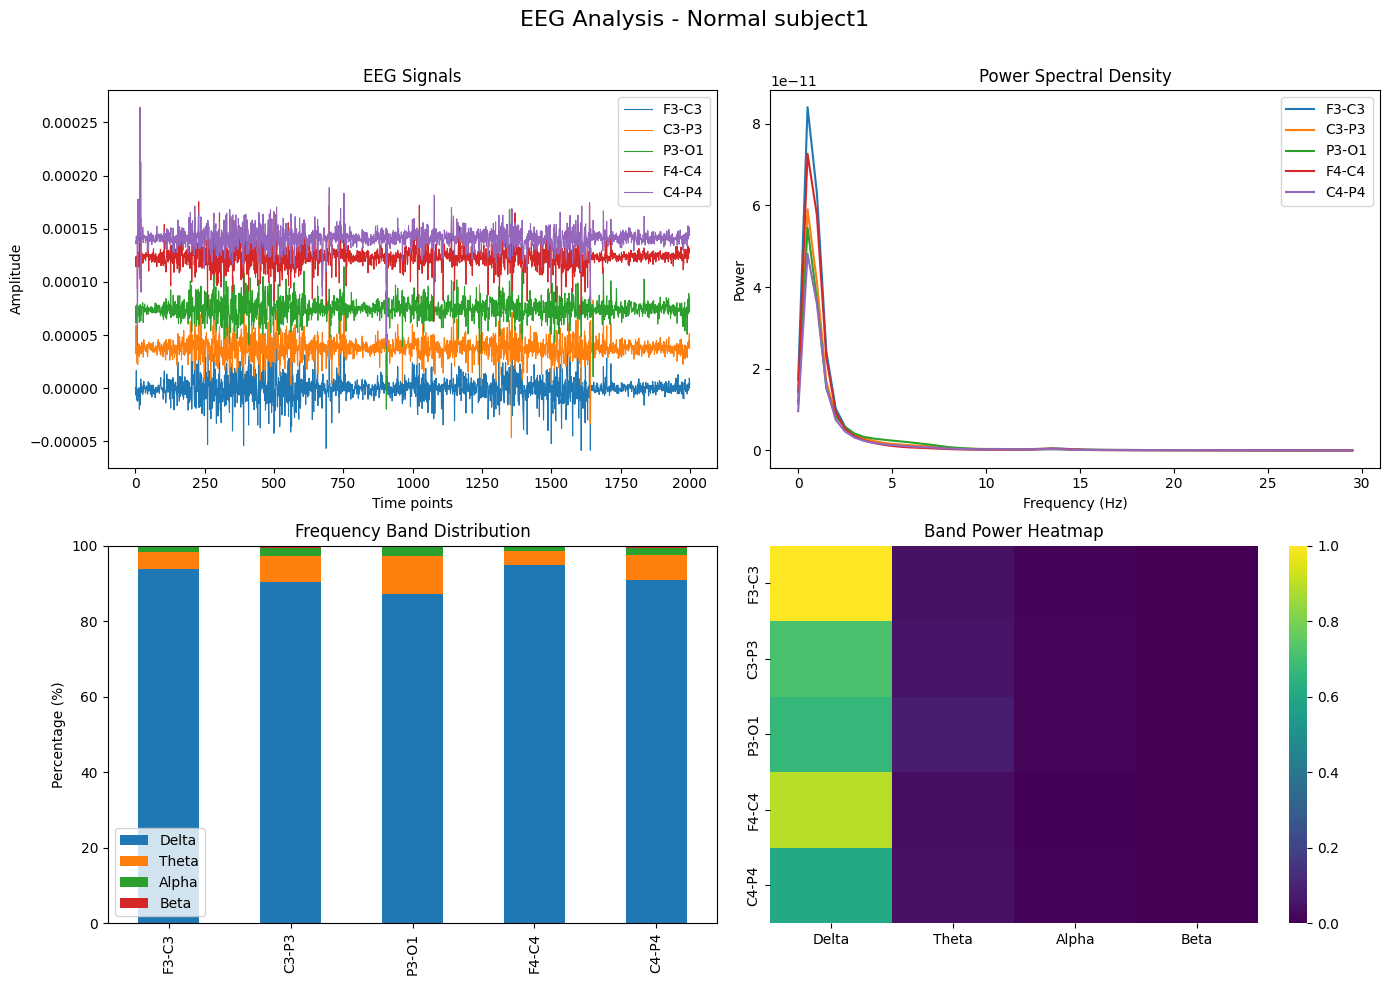

Processing file 2/2: /content/drive/MyDrive/CAP_Sleep_Data//n2.edf


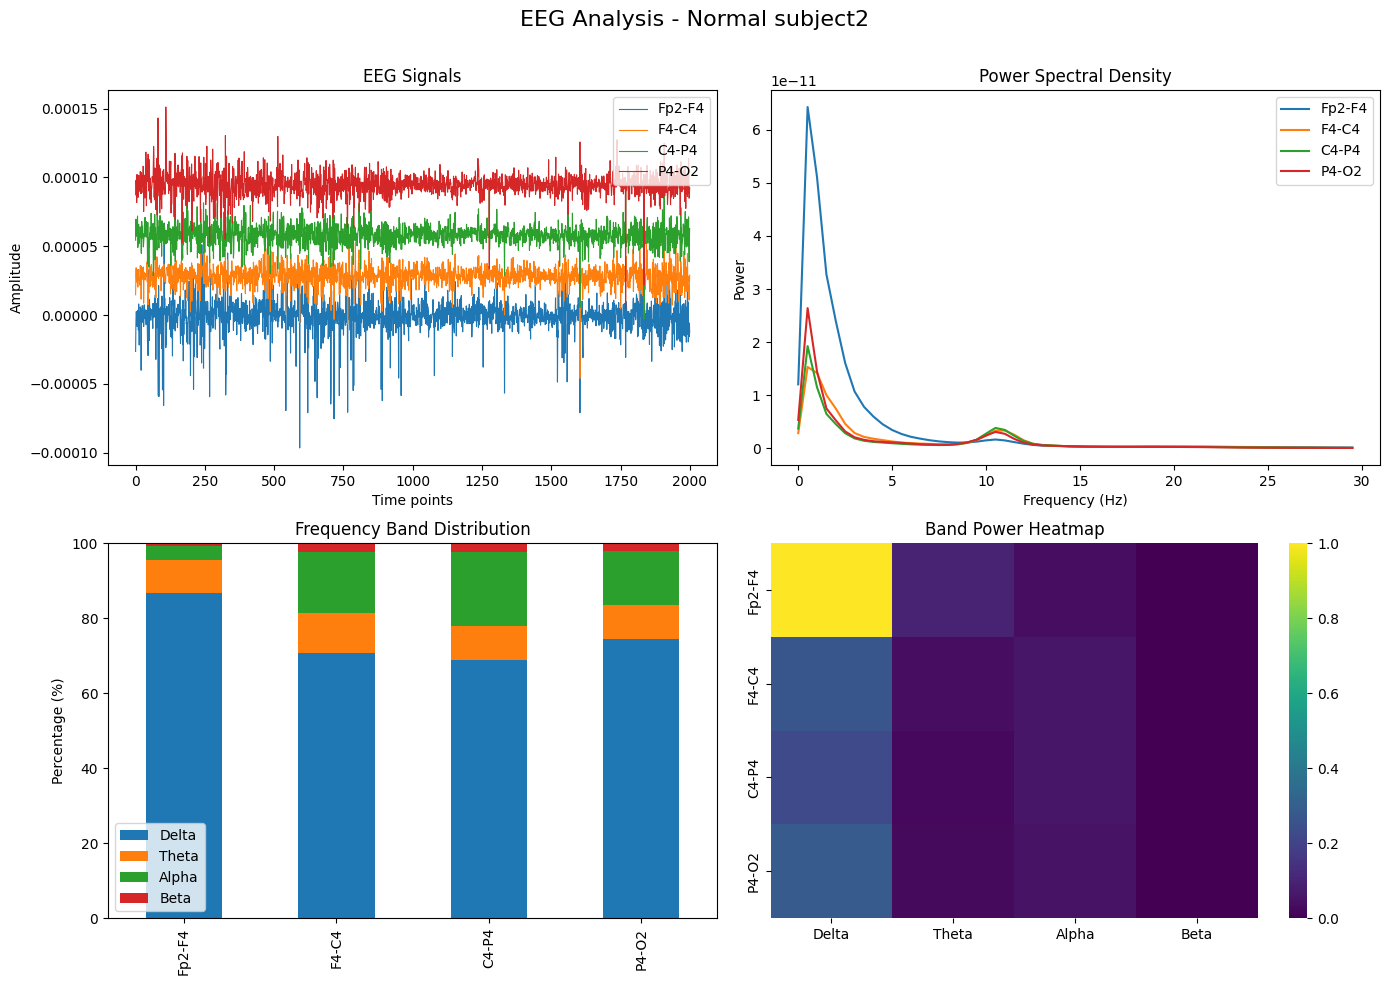

In [ ]:
file_paths = {
    'Normal': [
        f'{data_dir}/n1.edf',
        f'{data_dir}/n2.edf'
    ]
}
# Only analyze first half of data from each file with common channels
analyze_sleep_data(file_paths, max_duration=14000, common_channels=common_eeg_channels)



1. The EEG analyses of Normal subject1 and subject2 show strong indicators of healthy brain activity during sleep. Both subjects exhibit a high dominance of Delta waves across all channels, suggesting deep, restorative non-REM sleep. This is typical of normal sleep architecture.
2. The Beta band activity is minimal, which aligns with relaxed or sleep states and rules out abnormal wakefulness or stress.
3. The Power Spectral Density plots further confirm strong power in low-frequency bands (Delta and Theta), with no abnormal high-frequency spikes. EEG waveforms appear smooth and consistent, free from artifacts or irregularities.
4. The band power heatmaps show balanced distribution across channels, reflecting symmetrical brain activity.






Analyzing Narcolepsy data:
Processing file 1/2: /content/drive/MyDrive/CAP_Sleep_Data//narco1.edf


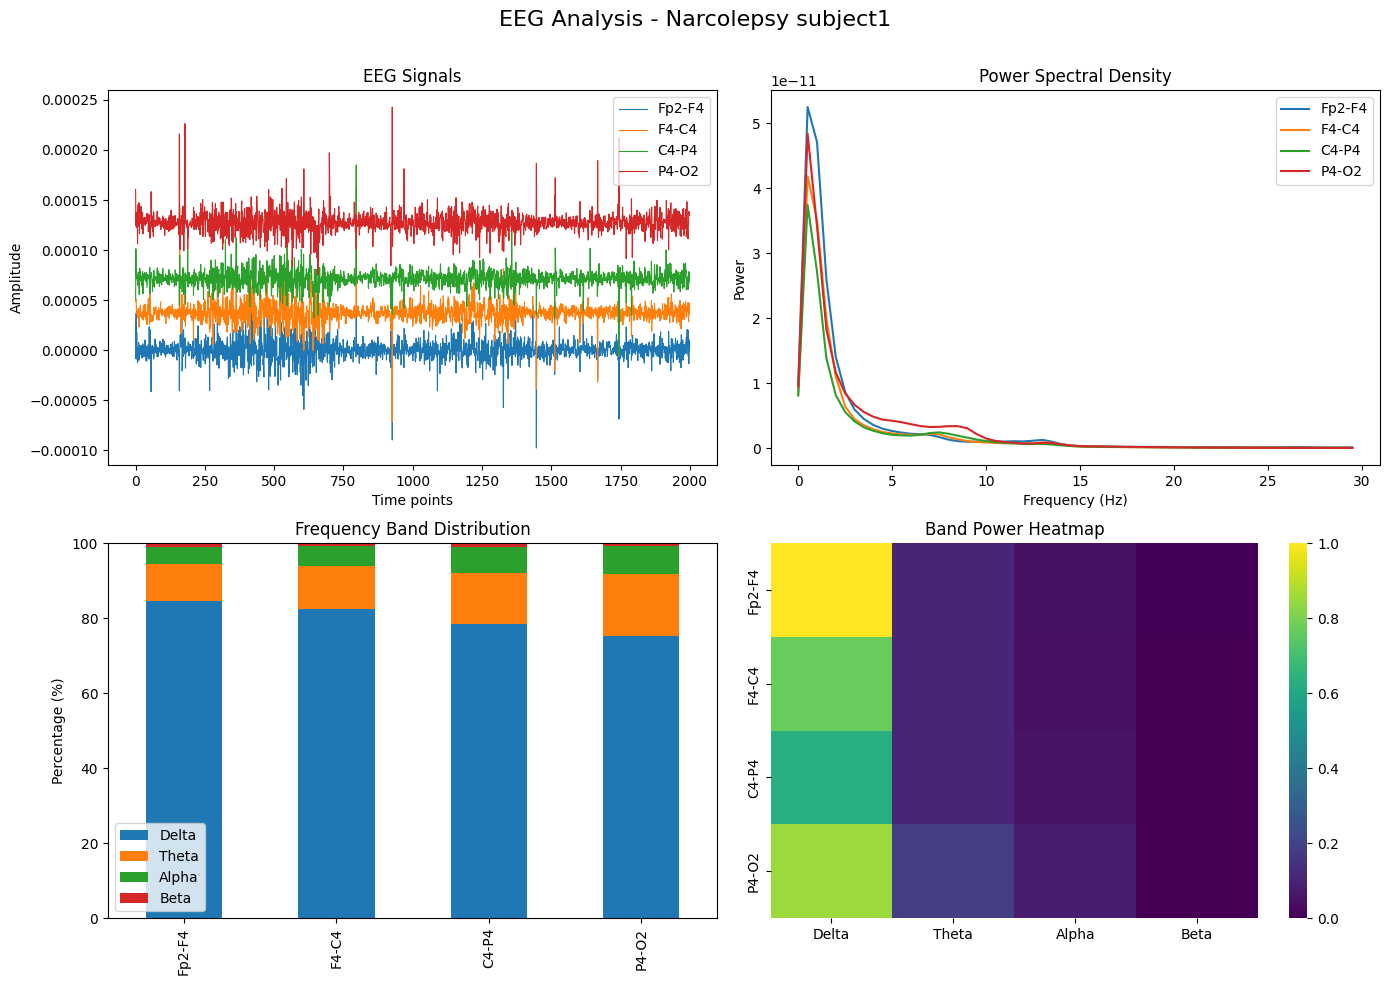

Processing file 2/2: /content/drive/MyDrive/CAP_Sleep_Data//narco2.edf


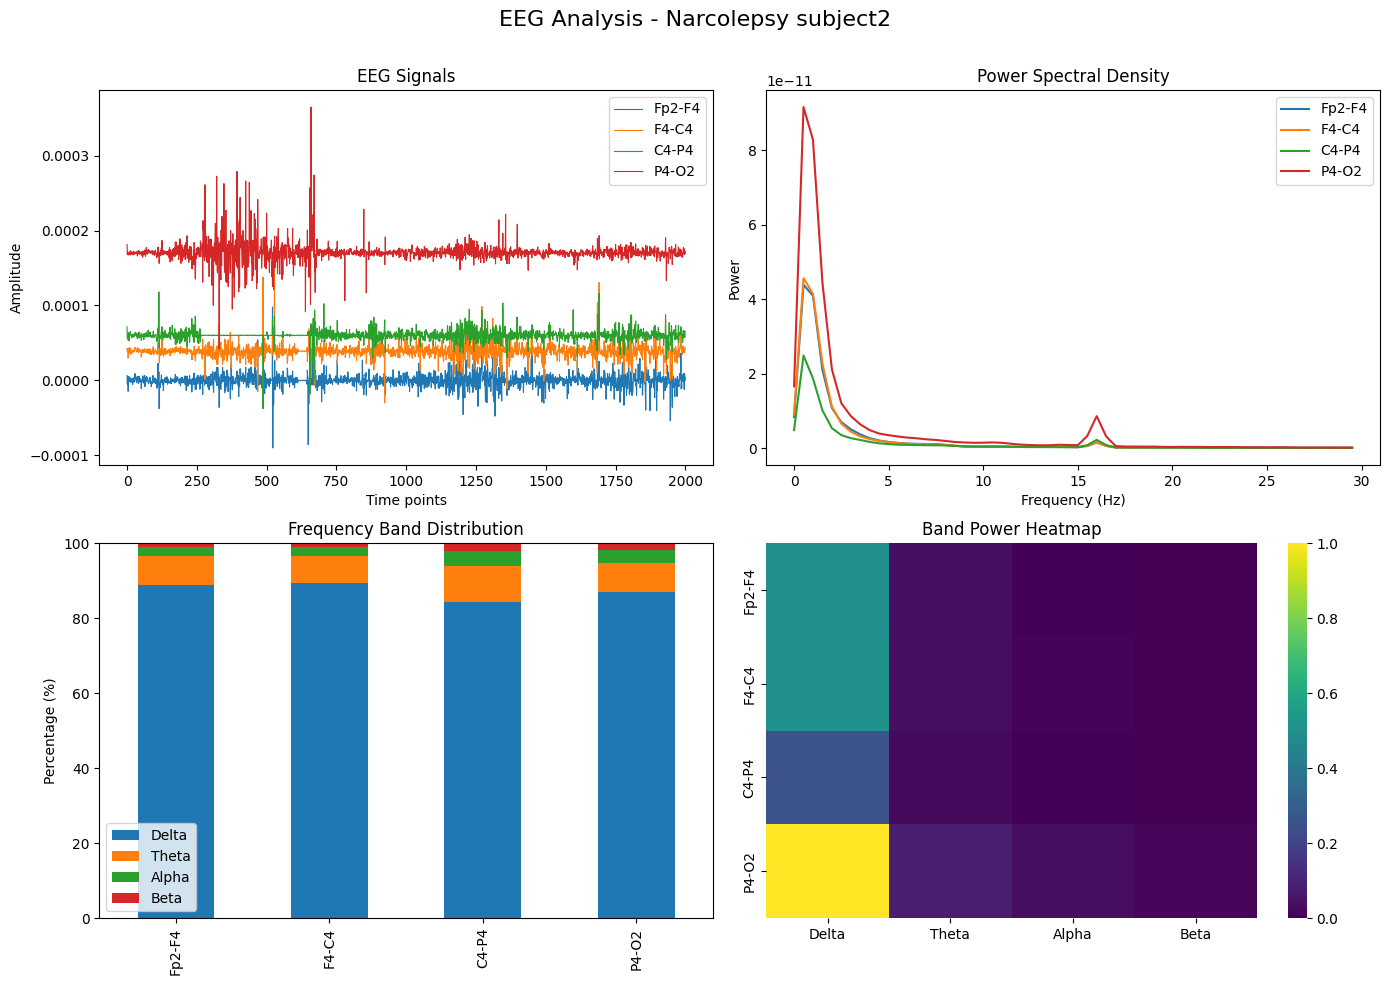

In [ ]:
file_paths = {
    'Narcolepsy': [
        f'{data_dir}/narco1.edf',
        f'{data_dir}/narco2.edf'
    ]
}

# Only analyze first half of data from each file with common channels
analyze_sleep_data(file_paths, max_duration=14000, common_channels=common_eeg_channels)

1. EEG analysis of Narcolepsy subject1 and subject2 shows disrupted sleep activity across all brain areas. Delta waves dominate across all channels — from front (Fp2-F4) to back (P4-O2) — suggesting deep sleep signals are appearing where and when they shouldn’t.

2. Higher-frequency signals (Theta, Alpha, Beta) are weak across the board, indicating poor sleep stage transitions and low brain engagement.

3. P4-O2, linked to the back of the brain, shows unusually high power, pointing to irregular REM-related activity.

4. Power Spectral Density plots and heatmaps confirm narrow frequency focus and uneven Delta power, especially in parietal-occipital regions, supporting signs of abnormal sleep regulation typical in narcolepsy.


Analyzing Insomnia data:
Processing file 1/2: /content/drive/MyDrive/CAP_Sleep_Data//ins1.edf


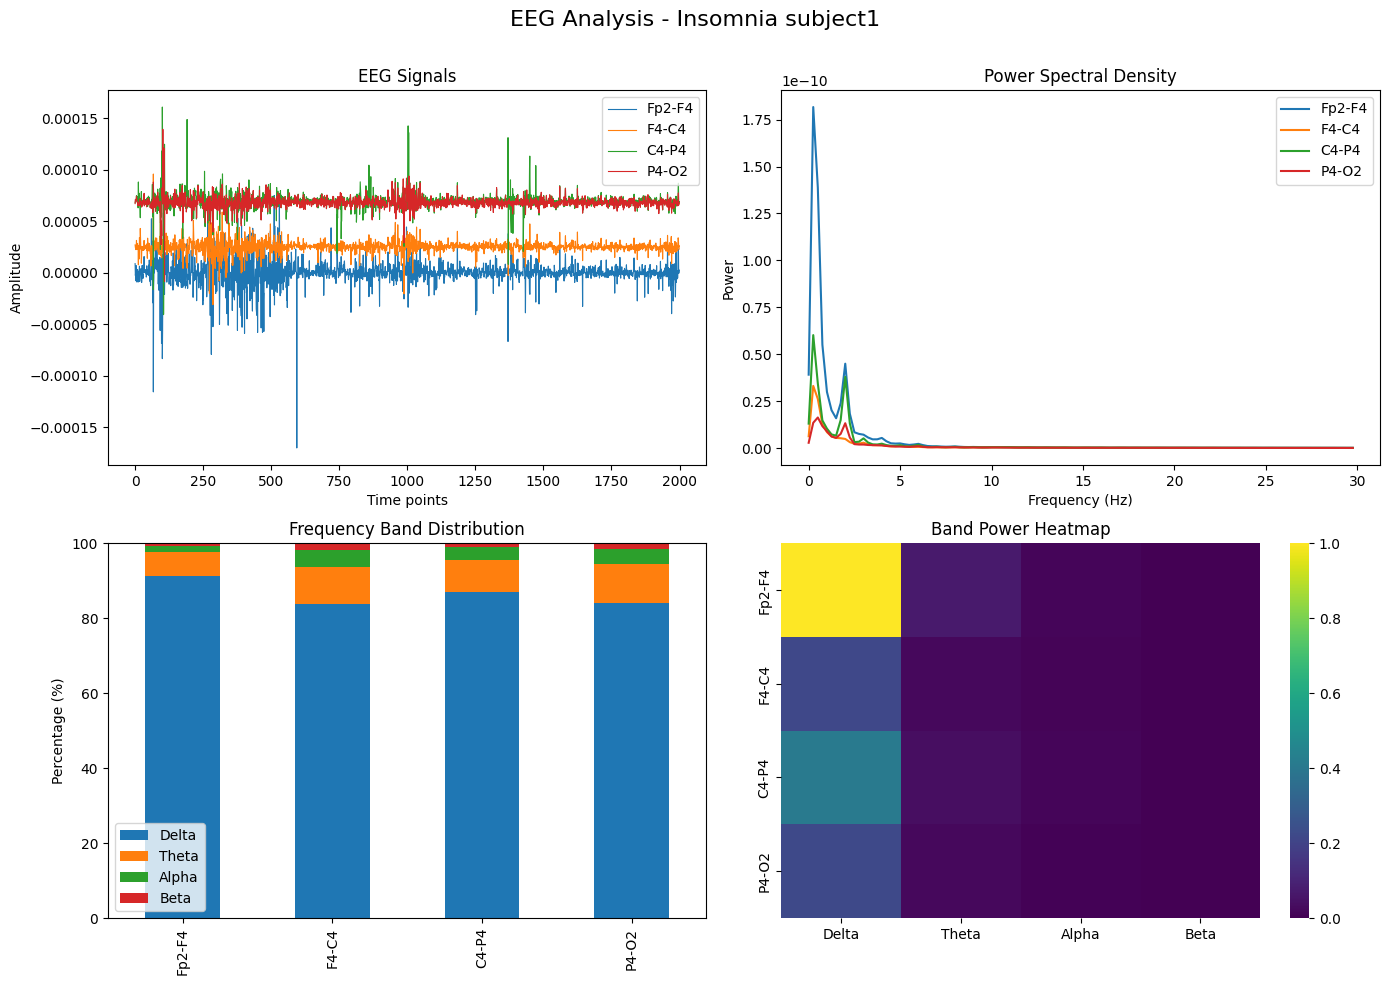

Processing file 2/2: /content/drive/MyDrive/CAP_Sleep_Data//ins2.edf


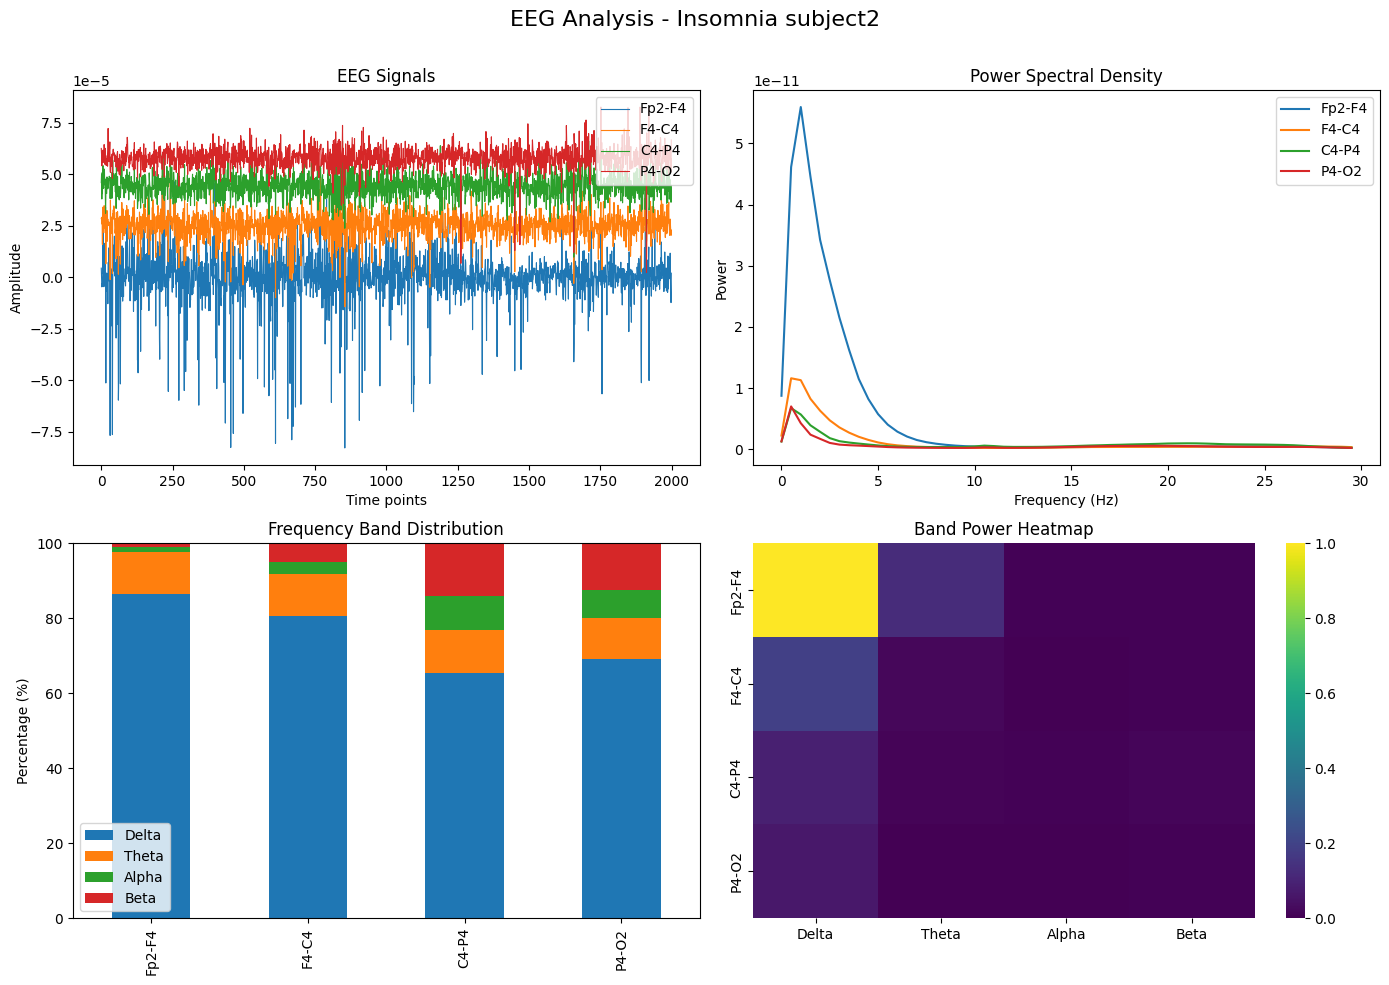

In [ ]:
file_paths = {
    'Insomnia': [
        f'{data_dir}/ins1.edf',
        f'{data_dir}/ins2.edf'
    ]
}
# Only analyze first half of data from each file with common channels
analyze_sleep_data(file_paths, max_duration=14000, common_channels=common_eeg_channels)

1. Insomnia Subject 1: Delta waves dominate in all regions, especially frontal (Fp2-F4), with very low Alpha and Beta activity. PSD shows a sharp peak at low frequency, and C4-P4 stands out with slightly higher Delta power. Overall, there's reduced variation across frequencies, indicating shallow, fragmented sleep.

2. Insomnia Subject 2: Fp2-F4 again shows high Delta power, but all other regions are relatively flat across bands. PSD drops steeply after Delta. Heatmap shows almost no presence of higher bands (Alpha, Beta), pointing to a lack of normal sleep depth progression

# TDA And Channel Activity Heatmap

*Time Domain Analysis* changes over time, focusing on waveform patterns to sleep stages.

*Channel Activity Heatmap* visualizes EEG signal activity (e.g., power or amplitude) across channels over time, helping to identify spatial brain patterns and activity levels.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from scipy import signal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def load_edf_data(file_path, max_samples=None):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    data = raw.get_data()
    if max_samples and data.shape[1] > max_samples:
        data = data[:, :max_samples]
    return torch.tensor(data, device=device, dtype=torch.float32), raw.ch_names

def preprocess_data(data, ch_names):
    data = data - torch.mean(data, dim=1, keepdim=True)
    return data

def generate_visualizations(data_dict):
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    sns.heatmap(data_dict['mean_channels'].cpu().numpy(), cmap='viridis',
                xticklabels=False, annot=False,
                cbar_kws={'label': 'Signal Amplitude'})
    plt.title(f'Channel Activity Heatmap - {data_dict["type"]}')

    plt.subplot(1, 2, 2)
    plt.plot(data_dict['time_data'].cpu().numpy().T)
    plt.title(f'Time Domain Signals - {data_dict["type"]}')
    plt.xlabel('Time Points')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

def analyze_sleep_data(file_paths, max_samples=100000):
    """
    Analyze sleep data, dynamically adjusting to the minimum number of channels
    """
    results = {}

    for data_type, paths in file_paths.items():
        all_data = []
        ch_names = None
        min_channels = float('inf')  # Track minimum channels across files

        # First pass: Determine minimum number of channels
        for path in paths:
            data, ch_names_file = load_edf_data(path, max_samples=max_samples)
            min_channels = min(min_channels, len(ch_names_file))

        # Second pass: Load and preprocess with consistent channels
        for path in paths:
            data, ch_names_file = load_edf_data(path, max_samples=max_samples)
            # Truncate to minimum number of channels
            data = data[:min_channels]
            ch_names_file = ch_names_file[:min_channels]
            processed_data = preprocess_data(data, ch_names_file)
            all_data.append(processed_data)
            if ch_names is None:
                ch_names = ch_names_file  # Use first file's channel names

        # Truncate to shortest length
        min_samples = min(d.shape[1] for d in all_data)
        all_data = [d[:, :min_samples] for d in all_data]

        # Stack and average
        stacked_data = torch.stack(all_data, dim=0).to(device)
        avg_data = torch.mean(stacked_data, dim=0)

        # Compute PSD on CPU
        freqs, psds = signal.welch(avg_data.cpu().numpy(), fs=100, axis=1)

        results[data_type] = {
            'type': data_type,
            'mean_channels': avg_data,
            'ch_names': ch_names,
            'freqs': freqs,
            'psds': torch.tensor(psds, device=device),
            'time_data': avg_data,
            'channel_variance': torch.var(avg_data, dim=1)
        }

        generate_visualizations(results[data_type])

    return results

Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/n1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Reading 0 ... 17725439  =      0.000 ... 34619.998 secs...
Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/n2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22579199  =      0.000 ... 44099.998 secs...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/n1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 17725439  =      0.000 ... 34619.998 secs...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/n2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22579199  =      0.000 ... 44099.998 secs...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)


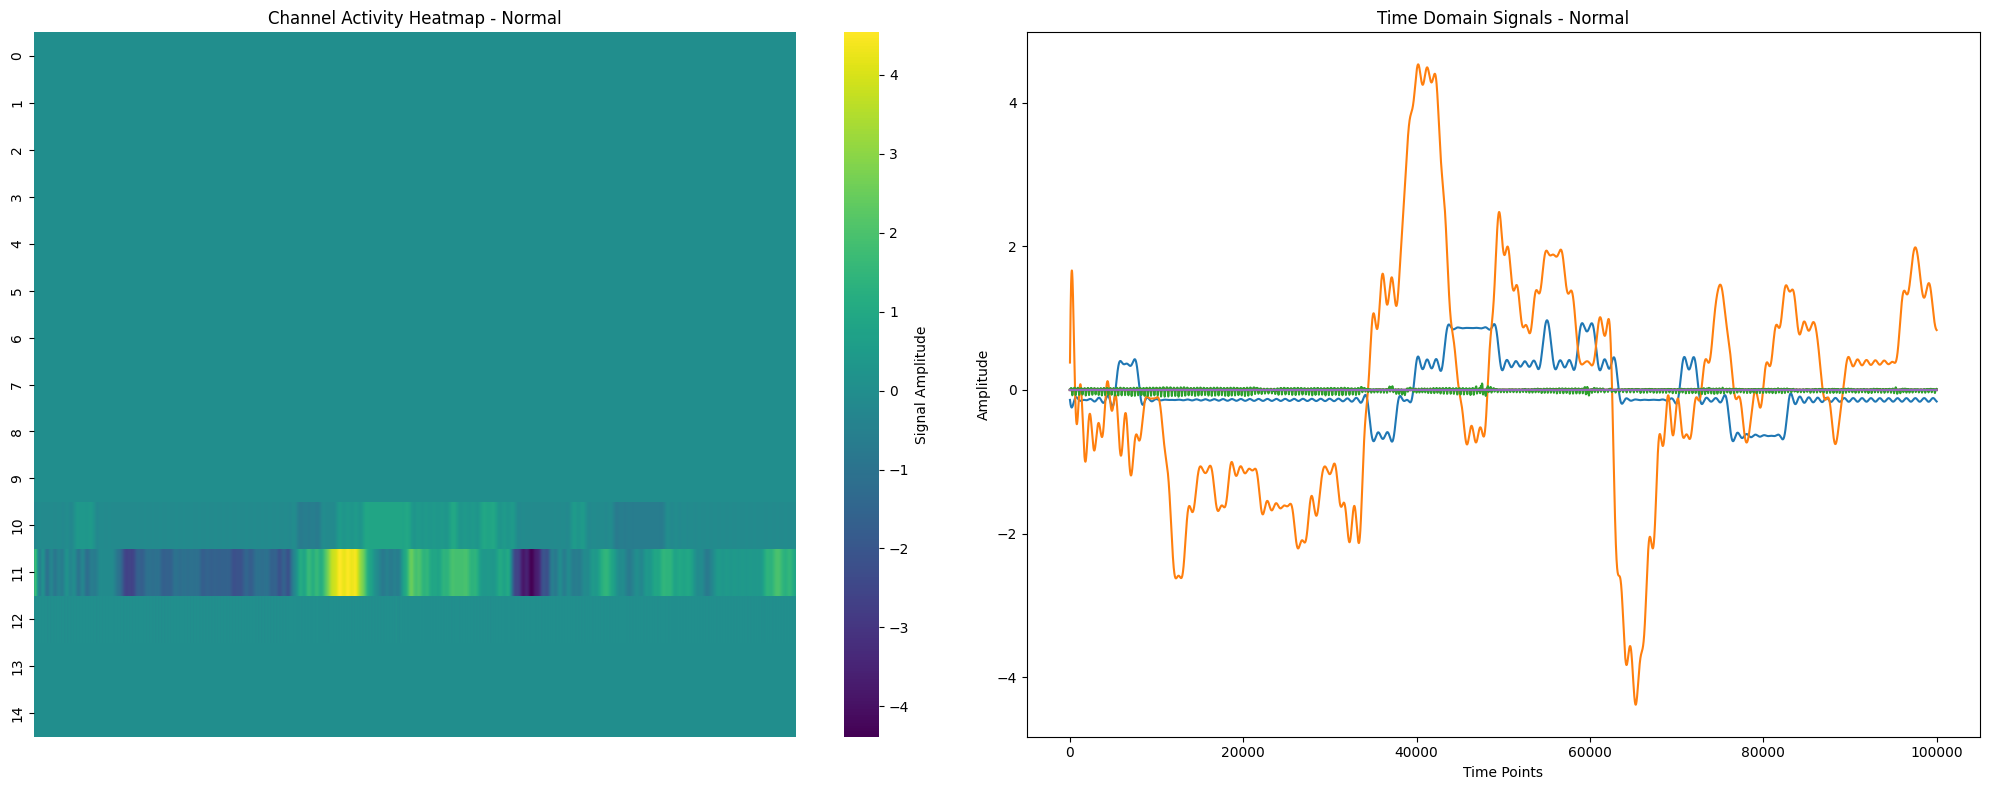

In [ ]:
file_paths = {
    'Normal': [
        '/content/drive/MyDrive/CAP_Sleep_Data/n1.edf',
        '/content/drive/MyDrive/CAP_Sleep_Data/n2.edf'
    ]
}
results = analyze_sleep_data(file_paths, max_samples=100000)

Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/narco1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 17326079  =      0.000 ... 33839.998 secs...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/narco2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 17648639  =      0.000 ... 34469.998 secs...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/narco1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 17326079  =      0.000 ... 33839.998 secs...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/narco2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 17648639  =      0.000 ... 34469.998 secs...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Highpass cutoff frequency 10.0 is greater than lowpass cutoff frequency 3.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True)


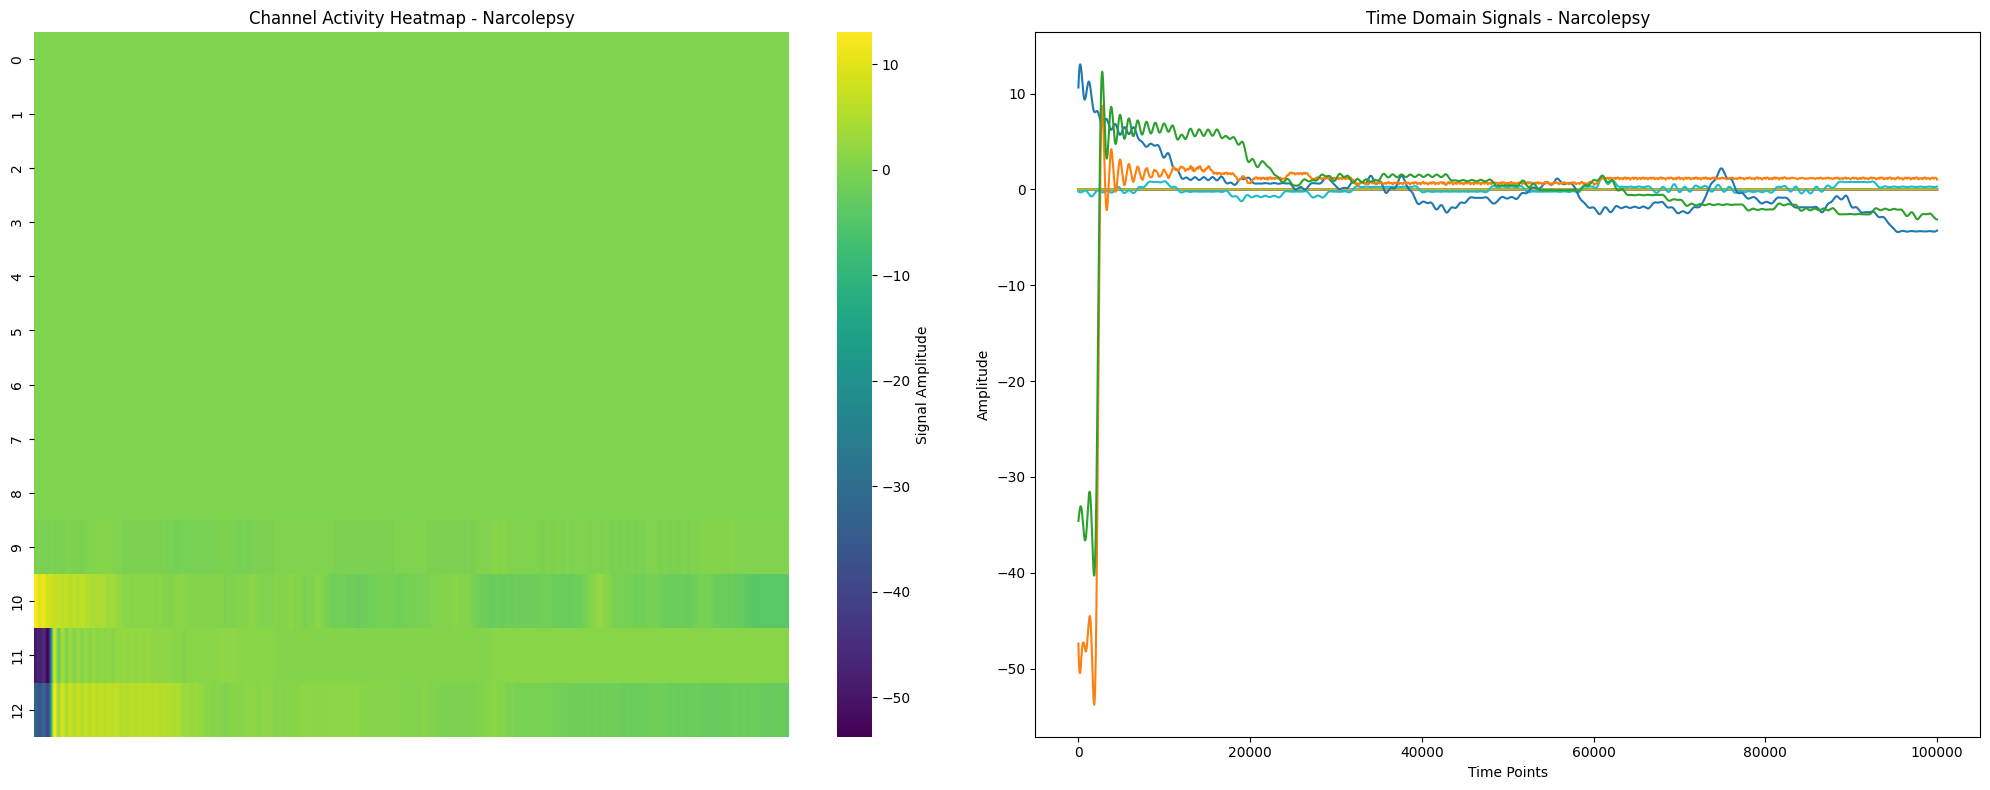

In [ ]:
file_paths = {
    'Narcolepsy': [
        '/content/drive/MyDrive/CAP_Sleep_Data/narco1.edf',
        '/content/drive/MyDrive/CAP_Sleep_Data/narco2.edf'
    ]
}
results = analyze_sleep_data(file_paths, max_samples=100000)

Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/ins1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12287999  =      0.000 ... 47999.996 secs...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/ins2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 25727999  =      0.000 ... 50249.998 secs...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/ins1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12287999  =      0.000 ... 47999.996 secs...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from /content/drive/MyDrive/CAP_Sleep_Data/ins2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 25727999  =      0.000 ... 50249.998 secs...


<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-6-9812321edb2c>:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True)


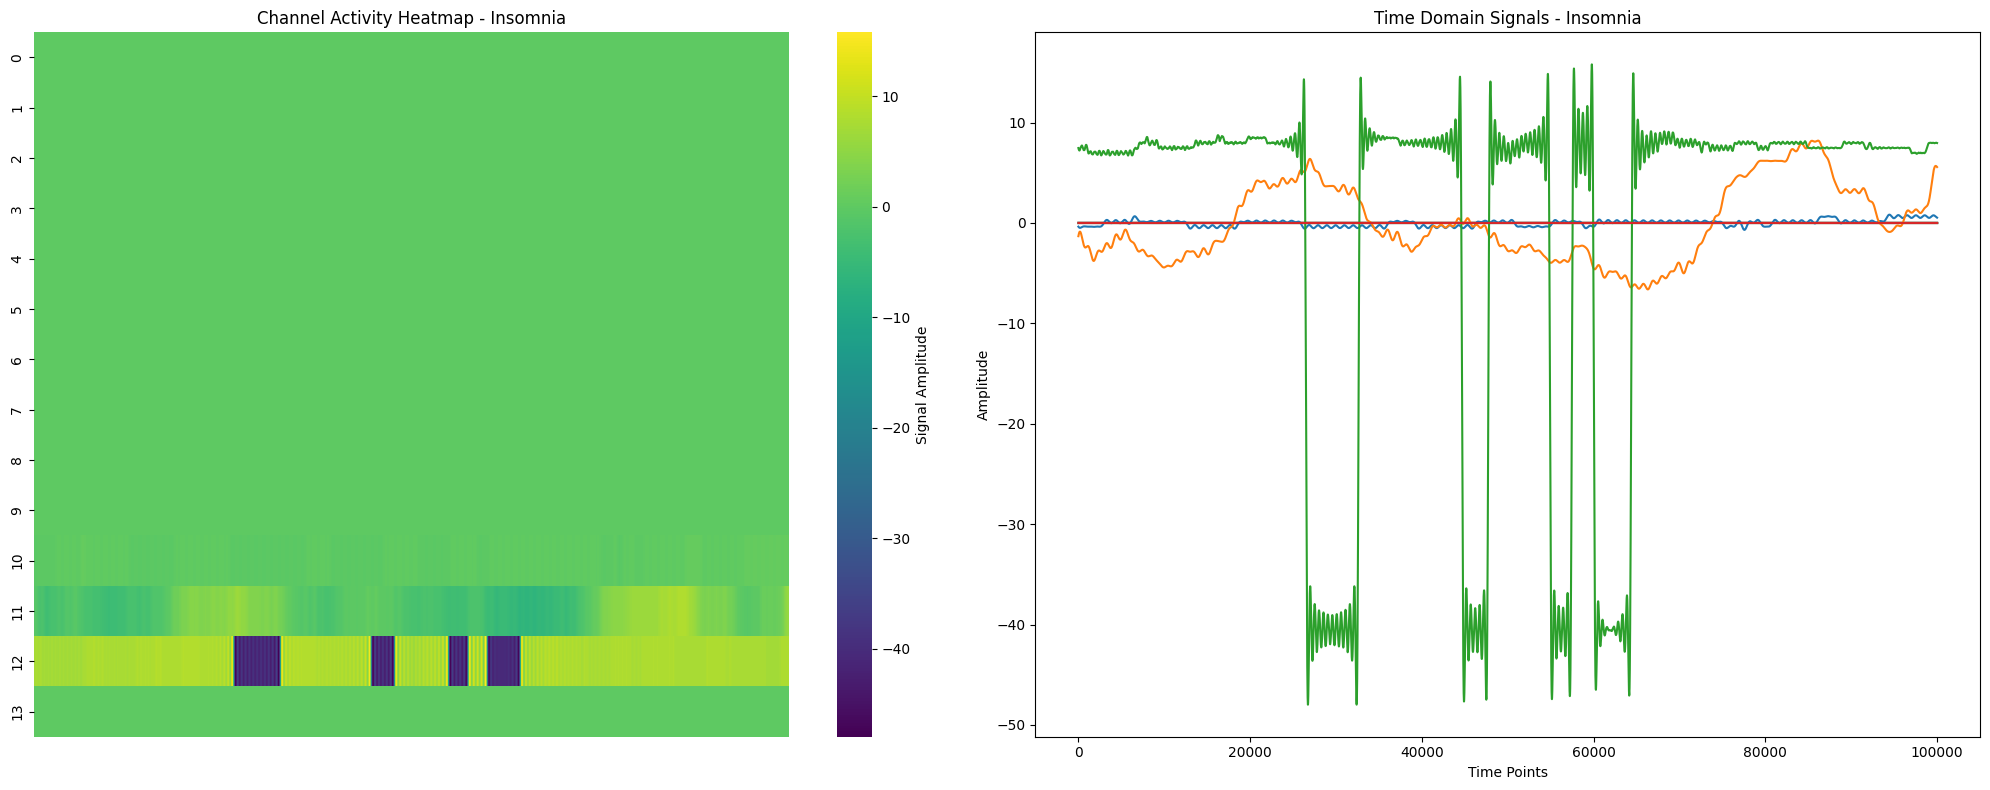

In [ ]:
file_paths = {
    'Insomnia': [
        '/content/drive/MyDrive/CAP_Sleep_Data/ins1.edf',
        '/content/drive/MyDrive/CAP_Sleep_Data/ins2.edf'
    ]
}
results = analyze_sleep_data(file_paths, max_samples=100000)